In [ ]:
import sys
assert sys.version_info >= (3, 5)
# Python ≥3.5 is required

In [ ]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [ ]:
# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd

In [ ]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving pacific.csv to pacific.csv


In [ ]:
pdata=pd.read_csv("pacific.csv")


In [ ]:
pdata.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,EP011949,UNNAMED,19490611,0,,TS,20.2N,106.3W,45,0,...,0,0,0,0,0,0,0,0,0,0
1,EP011949,UNNAMED,19490611,600,,TS,20.2N,106.4W,45,0,...,0,0,0,0,0,0,0,0,0,0
2,EP011949,UNNAMED,19490611,1200,,TS,20.2N,106.7W,45,0,...,0,0,0,0,0,0,0,0,0,0
3,EP011949,UNNAMED,19490611,1800,,TS,20.3N,107.7W,45,0,...,0,0,0,0,0,0,0,0,0,0
4,EP011949,UNNAMED,19490612,0,,TS,20.4N,108.6W,45,0,...,0,0,0,0,0,0,0,0,0,0


creating a training and testing det of the pacific dataset. it will be split as 80% training and 20% testing

In [ ]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))  # Shuffle the indices
    test_set_size = int(len(data) * test_ratio)          # Calculate test set size
    test_indices = shuffled_indices[:test_set_size]      # Get indices for test set
    train_indices = shuffled_indices[test_set_size:]     # Get indices for train set
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(pdata, 0.2)

In [ ]:
print("Training set size:", len(train_set))

Training set size: 20910


In [ ]:
print("Testing set size:", len(test_set))

Testing set size: 5227


Creating wind max speed categories for stratified sampling

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [ ]:
pdata = pd.read_csv("pacific.csv")

In [ ]:
pdata["wind_cat"] = pd.cut(pdata["Maximum Wind"],
                           bins=[0, 50, 100, 150, 200, np.inf],
                           labels=[1, 2, 3, 4, 5])

In [ ]:
pdata["wind_cat"].value_counts()

,count
wind_cat,
1,17495
2,7453
3,1179
4,10
5,0


<Axes: >

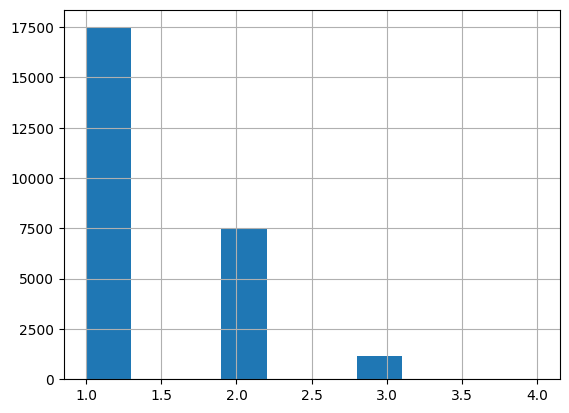

In [ ]:
pdata["wind_cat"].hist()

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


In [ ]:
for train_index, test_index in split.split(pdata, pdata["wind_cat"]):
    strat_train_set = pdata.loc[train_index]
    strat_test_set = pdata.loc[test_index]

In [ ]:
strat_test_set["wind_cat"].value_counts() / len(strat_test_set)

,count
wind_cat,
1,0.669281
2,0.285195
3,0.045142
4,0.000383
5,0.000000


In [ ]:
pdata["wind_cat"].value_counts() / len(pdata)

,count
wind_cat,
1,0.669358
2,0.285151
3,0.045108
4,0.000383
5,0.000000


In [ ]:
def wind_cat_proportions(data):
    return data["wind_cat"].value_counts() / len(data)
train_set, test_set = train_test_split(pdata, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": wind_cat_proportions(pdata),
    "Stratified": wind_cat_proportions(strat_test_set),
    "Random": wind_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100


In [ ]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
wind_cat,,,,,
1,0.669358,0.669281,0.676932,1.131576,-0.011477
2,0.285151,0.285195,0.281943,-1.124994,0.015355
3,0.045108,0.045142,0.040933,-9.255539,0.073331
4,0.000383,0.000383,0.000191,-50.005738,-0.011477
5,0.000000,0.000000,0.000000,NaN,NaN


In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("wind_cat", axis=1, inplace=True)

Prepare the Data for Machine Learning Algorithms

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

In [ ]:
pdata = pd.read_csv("pacific.csv")

In [ ]:
max_wind_ix, min_pressure_ix, lat_ix, lon_ix = 6, 7, 4, 5

In [ ]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_pressure_per_wind=True):
        self.add_pressure_per_wind = add_pressure_per_wind
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[:, max_wind_ix] = pd.to_numeric(X[:, max_wind_ix], errors='coerce')
        X[:, min_pressure_ix] = pd.to_numeric(X[:, min_pressure_ix], errors='coerce')
        X[:, lat_ix] = pd.to_numeric(X[:, lat_ix], errors='coerce')
        X[:, lon_ix] = pd.to_numeric(X[:, lon_ix], errors='coerce')

        wind_pressure_ratio = X[:, max_wind_ix] / (X[:, min_pressure_ix] + 1e-5)
        wind_to_lat_ratio = X[:, max_wind_ix] / (X[:, lat_ix] + 1e-5)

        if self.add_pressure_per_wind:
            pressure_to_longitude = X[:, min_pressure_ix] / (X[:, lon_ix] + 1e-5)
            return np.c_[X, wind_pressure_ratio, wind_to_lat_ratio, pressure_to_longitude]
        else:
            return np.c_[X, wind_pressure_ratio, wind_to_lat_ratio]

attr_adder = CombinedAttributesAdder(add_pressure_per_wind=True)
pdata_extra_attribs = attr_adder.transform(pdata.values)

In [ ]:
pdata_extra_attribs = pd.DataFrame(
    pdata_extra_attribs,
    columns=list(pdata.columns) + ["wind_pressure_ratio", "wind_to_lat_ratio", "pressure_to_longitude"],
    index=pdata.index
)


In [ ]:
pdata_extra_attribs.tail()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,wind_pressure_ratio,wind_to_lat_ratio,pressure_to_longitude
26132,EP222015,SANDRA,20151128,1200,NaN,NaN,NaN,NaN,35,1002,...,0,0,0,0,0,0,0,NaN,NaN,NaN
26133,EP222015,SANDRA,20151128,1800,NaN,NaN,NaN,NaN,30,1007,...,0,0,0,0,0,0,0,NaN,NaN,NaN
26134,EP222015,SANDRA,20151129,0,NaN,NaN,NaN,NaN,30,1008,...,0,0,0,0,0,0,0,NaN,NaN,NaN
26135,EP222015,SANDRA,20151129,600,NaN,NaN,NaN,NaN,25,1009,...,0,0,0,0,0,0,0,NaN,NaN,NaN
26136,EP222015,SANDRA,20151129,1200,NaN,NaN,NaN,NaN,20,1010,...,0,0,0,0,0,0,0,NaN,NaN,NaN


In [ ]:
pdata_extra_attribs.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,wind_pressure_ratio,wind_to_lat_ratio,pressure_to_longitude
0,EP011949,UNNAMED,19490611,0,NaN,NaN,NaN,NaN,45,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,EP011949,UNNAMED,19490611,600,NaN,NaN,NaN,NaN,45,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,EP011949,UNNAMED,19490611,1200,NaN,NaN,NaN,NaN,45,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
3,EP011949,UNNAMED,19490611,1800,NaN,NaN,NaN,NaN,45,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,EP011949,UNNAMED,19490612,0,NaN,NaN,NaN,NaN,45,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
pdata = pd.read_csv("pacific.csv")

In [ ]:
max_wind_ix, min_pressure_ix, lat_ix, lon_ix = 6, 7, 4, 5

In [ ]:

numeric_features = ["Latitude", "Longitude", "Maximum Wind", "Minimum Pressure"]
categorical_features = []  # Include any categorical features if available


In [ ]:
# Convert float string values to numeric
numeric_data = pdata[numeric_features]
for feature in numeric_features:
    numeric_data[feature] = pd.to_numeric(numeric_data[feature], errors='coerce')
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),         #  missing values
    ('attribs_adder', CombinedAttributesAdder()),          #  new attributes
    ('std_scaler', StandardScaler()),                      # Normalize attributes
])



<ipython-input-63-68de5bab87fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_data[feature] = pd.to_numeric(numeric_data[feature], errors='coerce')
